# Intro
This is a notebook for doing evaluations for TabPFN's

You will need to run each of the following steps to initialize all the classes and functions but for the most part you can ignore these unless you want to dig in deeper.

The important note is that after running **Setup** you **must** restart your colab environment (top left, Runtime, restart runtime OR `ctrl+M .`)

The most relevant section for just running and experimenting is the **Experiment** section. You'll find any plots generated by using the _folder_ icon on the left and looking in `./plots`.

If you aren't aware `ctrl + ]` will fold all cells while `ctrl + [` will expand them all. You can also find the table of contents on the left for an easier time navigating.

**In order to get the fastest predictions you need to enable GPUs for the notebook:**
* Navigate to Edit→Notebook Settings
* select GPU from the Hardware Accelerator drop-down
(https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=oM_8ELnJq_wd)

**Note:**
The markers on the legend for the plots seems to not render, this may be due to some matplotlib version. If required, please try the most up-to-date

# Setup


In [147]:
from eval_utils import Results
from __future__ import annotations
from pathlib import Path
import pandas as pd
import openml
import numpy as np


In [3]:
def filer_df(df):
    columns = df.columns
    df = df.fillna(0)
    too_easy_dids = []
    for index, row in df.iterrows():
        try:
            dataset_id = int(row["dataset_id"])
        except:
            continue
        if dataset_id == 0:
            continue
        if bool(int(row["too_easy"])) and int(row["Remove"]) != 1 and int(row["Redundant"]) != 1:
            prefix_to_skip = ["BNG", "RandomRBF", "GTSRB", "CovPokElec", "PCam"]
            if not (np.any([row["dataset_name"].startswith(prefix) for prefix in
                                    prefix_to_skip]) or "mnist" in row["dataset_name"].lower() or "image" in row[
                                "dataset_name"].lower() or "cifar" in row["dataset_name"].lower() or row["dataset_id"] == 1414):
                too_easy_dids.append((dataset_id))
    return too_easy_dids
    # openml_list = openml.datasets.list_datasets([dataset_id])

    # if openml_list[dataset_id]["NumberOfClasses"] != 0.0:
    #     all_bool = []
    #     for i in range(5, 18):
    #         all_bool.append(bool(int(row[columns[i]])))
    #     if any(all_bool):
    #         continue
    #     # print(type(int(row["score_hbgt"] )))
    #     if bool(int(row["too_easy"])):
    #         score_logistic = float(row["score_logistic"].replace(',', '.') if isinstance(row["score_logistic"], str) else row["score_logistic"])
    #         score_hbgt = float(row["score_hbgt"].replace(',', '.') if isinstance(row["score_hbgt"], str) else row["score_hbgt"])
    #         if score_logistic >= 1.05 * score_hbgt:
    #             print(dataset_id) #, print(row["too_easy"]))
    # if row["too_easy"]:

df = pd.read_csv("Datasets tabular data benchmark - numerical_classif-2.csv")

152
153
1240
1352
1353
1355
1356
1359
1361
1362
41000
41671


In [45]:
indices = ["method", "seed"]
headers = ["metric", "dataset"]
df = pd.read_csv("result.csv", index_col=[0,1], header=[0,1])
# new_df = df.groupby(["method"]).mean().T.reset_index()[df.groupby(["method"]).mean().T.reset_index()["metric"] == "acc"]#  # .plot("scatter", x="dataset") #.groupby("metric") #.groupby("dataset") #.mean().T # ["acc"].reset_index() # .plot()
# .plot(kind="scatter", x="dataset", y="acc")
# plt.save_fig("~/TabPFN/acc.png")
# import matplotlib.pyplot as plt
# ax = df.groupby(["method"]).mean()["acc"].T.plot()
# plt.save_fig("~/TabPFN/acc.png")
# plt.save_figure("~/TabPFN/acc.png")
# plt.savefig("~/TabPFN/acc.png")
# plt.savefig("./TabPFN/acc.png")
# plt.savefig("./important/acc.png")
results = Results(df)

datasets_logistic = ["Hyperplane_10_1E-3", "Hyperplane_10_1E-4", "AirlinesCodrnaAdult", "BNG(anneal,1000,5)", "BNG(anneal,1000,10)", "BNG(anneal,5000,5)", "BNG(anneal,5000,10)", "BNG(anneal,10000,10)", "BNG(anneal.ORIG,1000,5)", "BNG(anneal.ORIG,1000,10)", "jungle_chess_2pcs_endgame_panther_elephant", "microaggregation2"]
datasets_selected = [dataset for dataset in results.datasets if dataset not in datasets_logistic]


In [161]:
def get_average_rank_table(results: Results):
    datasets = results.datasets
    metrics = sorted(results.metrics, reverse=True)
    # print(results.methods)
    df = results.df
    results_rank = {}
    results_score = {}
    for metric in metrics:
        if "time" in metric:
            continue
        metric_df = df[metric]
        dataset_rank_dfs = []
        dataset_mean_dfs = []
        for dataset in datasets:
            if dataset not in metric_df.columns:
                continue
            dataset_rank_df = metric_df[dataset].groupby('method').mean().rank(ascending=False)
            dataset_rank_dfs.append(dataset_rank_df)
            dataset_mean_dfs.append(metric_df[dataset])

        results_rank[metric] = pd.concat(dataset_rank_dfs).groupby("method").mean()
        
        results_score[metric] = pd.concat(dataset_mean_dfs).groupby("method").mean()
    score_df = pd.DataFrame(results_score).reset_index()
    rank_df = pd.DataFrame(results_rank).reset_index()
    final_table = rank_df.merge(score_df, on="method", suffixes=[" Mean Rank", " Mean Score"]).T
    final_table.columns = final_table.iloc[0]
    final_table = final_table.iloc[1:]
    return final_table

In [162]:
all_datasets_ranks = get_average_rank_table(results)
too_easy_datasets_ranks = get_average_rank_table(results.at(dataset=datasets_logistic))
selected_datasets_ranks = get_average_rank_table(results.at(dataset=datasets_selected))

In [163]:
def pprint(df):
    for column in df:
        df[column] = df[column].astype('float').round(decimals=2)

    print(df.to_markdown())

In [164]:
print("\nToo easy (13 datasets from old csv) + grinzstjan et al")
pprint(all_datasets_ranks)
print("\n\n\nToo easy (13 datasets from old csv)")
pprint(too_easy_datasets_ranks)
print("\n\n\ngrinzstjan et al")
pprint(selected_datasets_ranks)


Too easy (13 datasets from old csv) + grinzstjan et al
|                          |   decision_tree |   hist_gradient_boosting |   logistic |   mlp |   rf |
|:-------------------------|----------------:|-------------------------:|-----------:|------:|-----:|
| roc Mean Rank            |            4.19 |                     1.81 |       4.11 |  3.04 | 1.85 |
| ece Mean Rank            |            1.33 |                     4.3  |       3.26 |  2.52 | 3.59 |
| cross_entropy Mean Rank  |            1.37 |                     4.48 |       2.37 |  3.19 | 3.59 |
| brier_score Mean Rank    |            1.37 |                     4.48 |       2.63 |  2.44 | 4.07 |
| acc Mean Rank            |            4.22 |                     1.56 |       3.43 |  3.76 | 2.04 |
| roc Mean Score           |            0.69 |                     0.8  |       0.72 |  0.75 | 0.81 |
| ece Mean Score           |            0.29 |                     0.04 |       0.07 |  0.14 | 0.04 |
| cross_entropy Mean Score

In [42]:
selected_datasets_ranks

method,decision_tree,hist_gradient_boosting,logistic,mlp,rf
acc Mean Rank,3.933333,1.366667,4.166667,3.9,1.633333
brier_score Mean Rank,1.4,4.733333,2.333333,2.333333,4.2
cross_entropy Mean Rank,1.066667,4.8,2.6,2.466667,4.066667
ece Mean Rank,1.333333,4.466667,3.466667,2.733333,3.0
roc Mean Rank,4.466667,1.266667,4.0,3.466667,1.8
time Mean Rank,5.0,3.866667,2.333333,1.866667,1.933333
acc Mean Score,0.765674,0.830999,0.724789,0.747256,0.82884
brier_score Mean Score,0.468644,0.232313,0.35002,0.37789,0.238986
cross_entropy Mean Score,23.427463,0.361268,0.531119,2.555888,0.400683
ece Mean Score,0.234318,0.022265,0.042985,0.104066,0.038526


In [166]:
headers = ["metric", "dataset"]
indices = [
    "method",
    "optimization_metric",
    "optimization_time",
    "eval_position",
    "split",
]

if Path("predefined_results.csv").exists():
    df = pd.read_csv(
        "predefined_results.csv",
        index_col=list(range(len(indices))),
        header=list(range(len(headers))),
    )
    result = Results(df)

In [167]:
datasets = [dataset.name for dataset in test_datasets]
all_datasets_ranks = get_average_rank_table(results=result.at(method=['xgb', 'xgb_default', 'logistic'], dataset=datasets))


In [168]:
pprint(all_datasets_ranks)

|                          |   logistic |   xgb |   xgb_default |
|:-------------------------|-----------:|------:|--------------:|
| roc Mean Rank            |       2.03 |  1.5  |          2.47 |
| ece Mean Rank            |       2.2  |  2.43 |          1.37 |
| cross_entropy Mean Rank  |       2.13 |  2.17 |          1.7  |
| brier_score Mean Rank    |       2.23 |  2.4  |          1.37 |
| acc Mean Rank            |       1.87 |  1.67 |          2.47 |
| roc Mean Score           |       0.88 |  0.89 |          0.87 |
| ece Mean Score           |       0.05 |  0.06 |          0.11 |
| cross_entropy Mean Score |       0.77 |  1.09 |          0.81 |
| brier_score Mean Score   |       0.25 |  0.25 |          0.29 |
| acc Mean Score           |       0.81 |  0.82 |          0.8  |


In [107]:
result = result.at(method=['xgb', 'xgb_default', 'logistic'])


In [116]:
result.df.groupby(['method']).mean().T.groupby('dataset').mean().rank()

method,logistic,xgb,xgb_default
dataset,,,
Australian,129.0,90.0,241.0
Australian.1,308.0,293.0,117.0
CPMP-2015-runtime-classification,140.0,148.0,338.0
CPMP-2015-runtime-classification.1,319.0,338.0,166.0
CastMetal1,110.0,79.0,228.0
...,...,...,...
wine.1,264.0,315.0,68.0
wisconsin,73.0,115.0,316.0
wisconsin.1,252.0,306.0,92.0


In [99]:

for metric in result.metrics:
    if "time" in metric:
        continue
    df_work = result.at(metric=[metric, "time"]).df
    df_work = df_work.groupby(["method"]).mean().T.groupby("metric").mean().T
    print(df_work.groupby('method').agg({metric:'mean', 'time': 'mean'}))

metric            roc         time
method                            
logistic     0.822176  1099.557547
xgb          0.845246  3607.387348
xgb_default  0.834545     0.154738
metric       cross_entropy         time
method                                 
logistic          0.612036  1099.557547
xgb               1.441325  3607.387348
xgb_default       0.650814     0.154738
metric            acc         time
method                            
logistic     0.776886  1099.557547
xgb          0.806110  3607.387348
xgb_default  0.795503     0.154738
metric       brier_score         time
method                               
logistic        0.292556  1099.557547
xgb             0.289524  3607.387348
xgb_default     0.309512     0.154738
metric            ece         time
method                            
logistic     0.082374  1099.557547
xgb          0.110097  3607.387348
xgb_default  0.128083     0.154738


In [104]:
df_work = result.at(metric=["roc", "time"]).df
df_work.T.groupby(["dataset"]).mean().T
# df_work = df_work.groupby(["method"]).mean().T.groupby("metric").mean().T
# print(df_work.groupby('method').agg({metric:'mean', 'time': 'mean'}))

dataset                                                                 Australian  \
method      optimization_metric optimization_time eval_position split                
logistic    roc_auc             3600.0            1000          1       613.914799   
                                                                2       589.891549   
                                                                3       612.818930   
                                                                4       590.000713   
                                                                5       632.718499   
xgb         roc_auc             3600.0            1000          1      1801.446103   
                                                                2      1802.198123   
                                                                3      1802.597823   
                                                                4      1801.582362   
                                                                5      1802.397157   
xgb_default roc_auc             3600.0            1000          1         0.489344   
                                                                2         0.488106   
                                                                3         0.486208   
                                                                4         0.501598   
                                                                5         0.500958   

dataset                                                                Australian.1  \
method      optimization_metric optimization_time eval_position split                 
logistic    roc_auc             3600.0            1000          1       1226.909134   
                                                                2       1178.875518   
                                                                3       1224.735065   
                                                                4       1179.082289   
                                                                5       1264.514705   
xgb         roc_auc             3600.0            1000          1       3601.965523   
                                                                2       3603.473378   
                                                                3       3604.292376   
                                                                4       3602.222282   
                                                                5       3603.862974   
xgb_default roc_auc             3600.0            1000          1          0.058844   
                                                                2          0.057707   
                                                                3          0.059501   
                                                                4          0.061196   
                                                                5          0.059335   

dataset                                                                CPMP-2015-runtime-classification  \
method      optimization_metric optimization_time eval_position split                                     
logistic    roc_auc             3600.0            1000          1                            775.920311   
                                                                2                            780.746264   
                                                                3                            795.636311   
                                                                4                            789.605132   
                                                                5                            809.276986   
xgb         roc_auc             3600.0            1000          1                           1805.960673   
                                                                2                           1814.881625   
                                                                3                           18

In [91]:
result.df.T.groupby(['metric']).mean().T.groupby('method').mean() #.rank().T.groupby('method').mean() #.T.groupby('metric').mean().T.rank(ascending=False)

metric,acc,brier_score,cross_entropy,ece,fit_time,inference_time,roc,time
method,,,,,,,,
logistic,0.776886,0.292556,0.612036,0.082374,0.067362,0.000214,0.822176,1099.557547
xgb,0.806110,0.289524,1.441325,0.110097,1.803934,0.017651,0.845246,3607.387348
xgb_default,0.795503,0.309512,0.650814,0.128083,0.146990,0.003018,0.834545,0.154738


In [12]:
import numpy as np

In [13]:
df = pd.DataFrame(data={'Animal': ['cat', 'penguin', 'dog',
                                   'spider', 'snake'],
                        'Number_legs': [4, 2, 4, 8, np.nan]})
df



df['default_rank'] = df['Number_legs'].rank()
df['max_rank'] = df['Number_legs'].rank(method='max')
df['desc_rank'] = df['Number_legs'].rank(ascending=False)

df['NA_bottom'] = df['Number_legs'].rank(na_option='bottom')
df['pct_rank'] = df['Number_legs'].rank(pct=True)
df




,Animal,Number_legs,default_rank,max_rank,desc_rank,NA_bottom,pct_rank
0,cat,4.0,2.5,3.0,2.5,2.5,0.625
1,penguin,2.0,1.0,1.0,4.0,1.0,0.250
2,dog,4.0,2.5,3.0,2.5,2.5,0.625
3,spider,8.0,4.0,4.0,1.0,4.0,1.000
4,snake,NaN,NaN,NaN,NaN,5.0,NaN


In [112]:
df.columns.levels

FrozenList([['acc', 'brier_score', 'cross_entropy', 'ece', 'roc', 'time'], ['AirlinesCodrnaAdult', 'BNG(anneal,1000,10)', 'BNG(anneal,1000,5)', 'BNG(anneal,10000,10)', 'BNG(anneal,5000,10)', 'BNG(anneal,5000,5)', 'BNG(anneal.ORIG,1000,10)', 'BNG(anneal.ORIG,1000,5)', 'Higgs', 'Hyperplane_10_1E-3', 'Hyperplane_10_1E-4', 'MagicTelescope', 'MiniBooNE', 'bank-marketing', 'california', 'covertype', 'credit', 'electricity', 'eye_movements', 'house_16H', 'jannis', 'jungle_chess_2pcs_endgame_panther_elephant', 'kdd_ipums_la_97-small', 'microaggregation2', 'phoneme', 'pol', 'wine']])

In [68]:
print(metrics)

Index(['roc', 'cross_entropy', 'acc', 'brier_score', 'ece', 'time'], dtype='object', name='metric')


In [83]:
from itertools import product
results = {"methods": [] ,"datasets" : []} #,"seeds": [] }'roc': [], 'cross_entropy': [], 'acc': [], 'brier_score': [], 'ece': [] 
metric_results = {}
for metric in metrics:
    metric_results[metric] = {**results, **{"score": []}}

for (
    metric,
    method,
    dataset,
    seed) in product(
        metrics,
        methods,
        datasets,
        seeds
    ):
    if metric in metric_results:
        
        metric_results[metric]["score"].append(df.loc[(method, seed), (metric, dataset)])
        # other_metrics = [met for met in metrics if met in results and met != metric]
        # for other_metric in other_metrics:
        #     results[other_metric].append(np.nan)
        metric_results[metric]["methods"].append(method)
        metric_results[metric]["datasets"].append(dataset)


In [ ]:
# print(len(results["datasets"]))
dfs = []
for metric in metric_results:
    print(metric_results[metric])
    break
    # dfs.append(pd.DataFrame(metric_results[metric]))


In [81]:
results.head()

,roc,cross_entropy,acc,brier_score,ece,methods,datasets
0,0.782412,NaN,NaN,NaN,NaN,decision_tree,MagicTelescope
1,0.841181,NaN,NaN,NaN,NaN,decision_tree,kdd_ipums_la_97-small
2,0.595672,NaN,NaN,NaN,NaN,decision_tree,microaggregation2
3,0.696735,NaN,NaN,NaN,NaN,decision_tree,credit
4,0.726597,NaN,NaN,NaN,NaN,decision_tree,covertype


In [43]:
# grouped_df = df.groupby(["metric"], axis=1)
# # for metric in ["roc", "cross_entropy", "acc", "brier_score", "ece"]:
# #     print(grouped_df["metric"])
# for key, item in grouped_df:
#     print(grouped_df.get_group(key), "\n\n")
new_df = df.droplevel(0)

columns = new_df.columns
# move dataset which is an index to a column
new_df = new_df.reset_index()



In [45]:
new_df
# for column in columns:
#     print(column[0])
#     # # concate mini dfs per method
#     mini_dfs = []
#     for column in columns:
#         t_1_df = df[["dataset", column]].copy()
#         t_1_df["method"] = column
#         t_1_df.columns = ["Dataset", f"{optimization_metric}", "method"]
#         mini_dfs.append(t_1_df)
#     df = pd.concat(mini_dfs)

metric  seed            roc                                                    \
dataset      MagicTelescope kdd_ipums_la_97-small microaggregation2    credit   
0        545       0.782412              0.841181          0.595672  0.696735   
1        545       0.932046              0.935325          0.755082  0.852535   
2        545       0.842083              0.933905          0.689300  0.814789   
3        545       0.889420              0.822186          0.759091  0.714959   
4        545       0.931711              0.941083          0.749405  0.844759   

metric                                                                         \
dataset covertype BNG(anneal,10000,10) Hyperplane_10_1E-4 BNG(anneal,1000,10)   
0        0.726597             0.528036           0.763146            0.508719   
1        0.875508             0.611405           0.930383            0.541617   
2        0.665893             0.515501           0.940687            0.485922   
3        0.826003             0.562016           0.940189            0.609052   
4        0.881157             0.648699           0.928386            0.593278   

metric                           ...  \
dataset BNG(anneal.ORIG,1000,5)  ...   
0                      0.512843  ...   
1                      0.525379  ...   
2                      0.483152  ...   
3                      0.513810  ...   
4                      0.622719  ...   

metric                                        time            \
dataset jungle_chess_2pcs_endgame_panther_elephant     Higgs   
0                                         0.355518  0.446817   
1                                         1.155980  0.673221   
2                                         1.043188  1.027906   
3                                         2.208635  6.011692   
4                                         0.546699  1.932822   

metric                                                           \
dataset BNG(anneal,1000,5)       pol bank-marketing electricity   
0                 0.420937  0.215281       0.215589    0.224699   
1                 2.052475  0.627228       0.514952    0.527702   
2                 1.192532  1.069844       0.952714    0.953843   
3                 1.314823  3.000965       0.825624    5.132117   
4                 1.187811  0.809283       0.933947    1.070518   

metric                                                                   
dataset AirlinesCodrnaAdult   phoneme BNG(anneal,5000,10) eye_movements  
0                  0.222294  0.323657            0.257108      0.303802  
1                  0.569372  0.486907            2.127459      0.604081  
2                  1.055812  1.144558            1.275809      1.006918  
3                  0.936474  2.120451            1.489000      0.913519  
4                  0.974401  0.627058            1.061212      1.345927  

[5 rows x 163 columns]

In [14]:
for dataset in new_all_df["dataset"]:
    new_all_df[new_all_df["dataset"] == dataset]["hist_gradient_boosting"] = new_df[new_df["dataset"] == dataset]["hist_gradient_boosting"]

/tmp/ipykernel_2041377/2556087799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_all_df[new_all_df["dataset"] == dataset]["hist_gradient_boosting"] = new_df[new_df["dataset"] == dataset]["hist_gradient_boosting"]


In [15]:
new_all_df

method,metric,dataset,decision_tree,hist_gradient_boosting,logistic,mlp,rf
0,acc,"BNG(anneal.ORIG,1000,5)",0.788896,0.860772,0.779876,0.863592,0.855612
1,acc,"BNG(anneal,10000,10)",0.904264,0.949792,0.844164,0.959844,0.939888
2,acc,"BNG(anneal.ORIG,1000,10)",0.702440,0.797880,0.759652,0.802424,0.796516
3,acc,microaggregation2,0.504400,0.627800,0.563200,0.630600,0.617800
4,acc,"BNG(anneal,5000,5)",0.903568,0.944952,0.845636,0.958804,0.939572
5,acc,"BNG(anneal,1000,10)",0.734844,0.833288,0.762644,0.849896,0.806292
6,acc,Hyperplane_10_1E-4,0.806580,0.902320,0.910852,0.911668,0.896124
7,acc,Hyperplane_10_1E-3,0.604312,0.696092,0.695632,0.698104,0.689192
8,acc,"BNG(anneal,1000,5)",0.792488,0.867040,0.766548,0.890404,0.848216
9,acc,"BNG(anneal,5000,10)",0.865968,0.919516,0.815200,0.936140,0.914472


In [6]:
plot_df = new_df.reset_index().drop(["metric", "index"], axis=1)

# plot_df = plot_df.replace({})
import matplotlib.pyplot as plt

In [7]:
plot_df

method,dataset,decision_tree,hist_gradient_boosting,logistic,mlp,rf
0,"BNG(anneal.ORIG,1000,5)",0.788896,0.860772,0.779876,0.863592,0.855612
1,"BNG(anneal,10000,10)",0.904264,0.949792,0.844164,0.959844,0.939888
2,"BNG(anneal.ORIG,1000,10)",0.702440,0.797880,0.759652,0.802424,0.796516
3,microaggregation2,0.504400,0.627800,0.563200,0.630600,0.617800
4,"BNG(anneal,5000,5)",0.903568,0.944952,0.845636,0.958804,0.939572
5,"BNG(anneal,1000,10)",0.734844,0.833288,0.762644,0.849896,0.806292
6,Hyperplane_10_1E-4,0.806580,0.902320,0.910852,0.911668,0.896124
7,Hyperplane_10_1E-3,0.604312,0.696092,0.695632,0.698104,0.689192
8,"BNG(anneal,1000,5)",0.792488,0.867040,0.766548,0.890404,0.848216
9,"BNG(anneal,5000,10)",0.865968,0.919516,0.815200,0.936140,0.914472


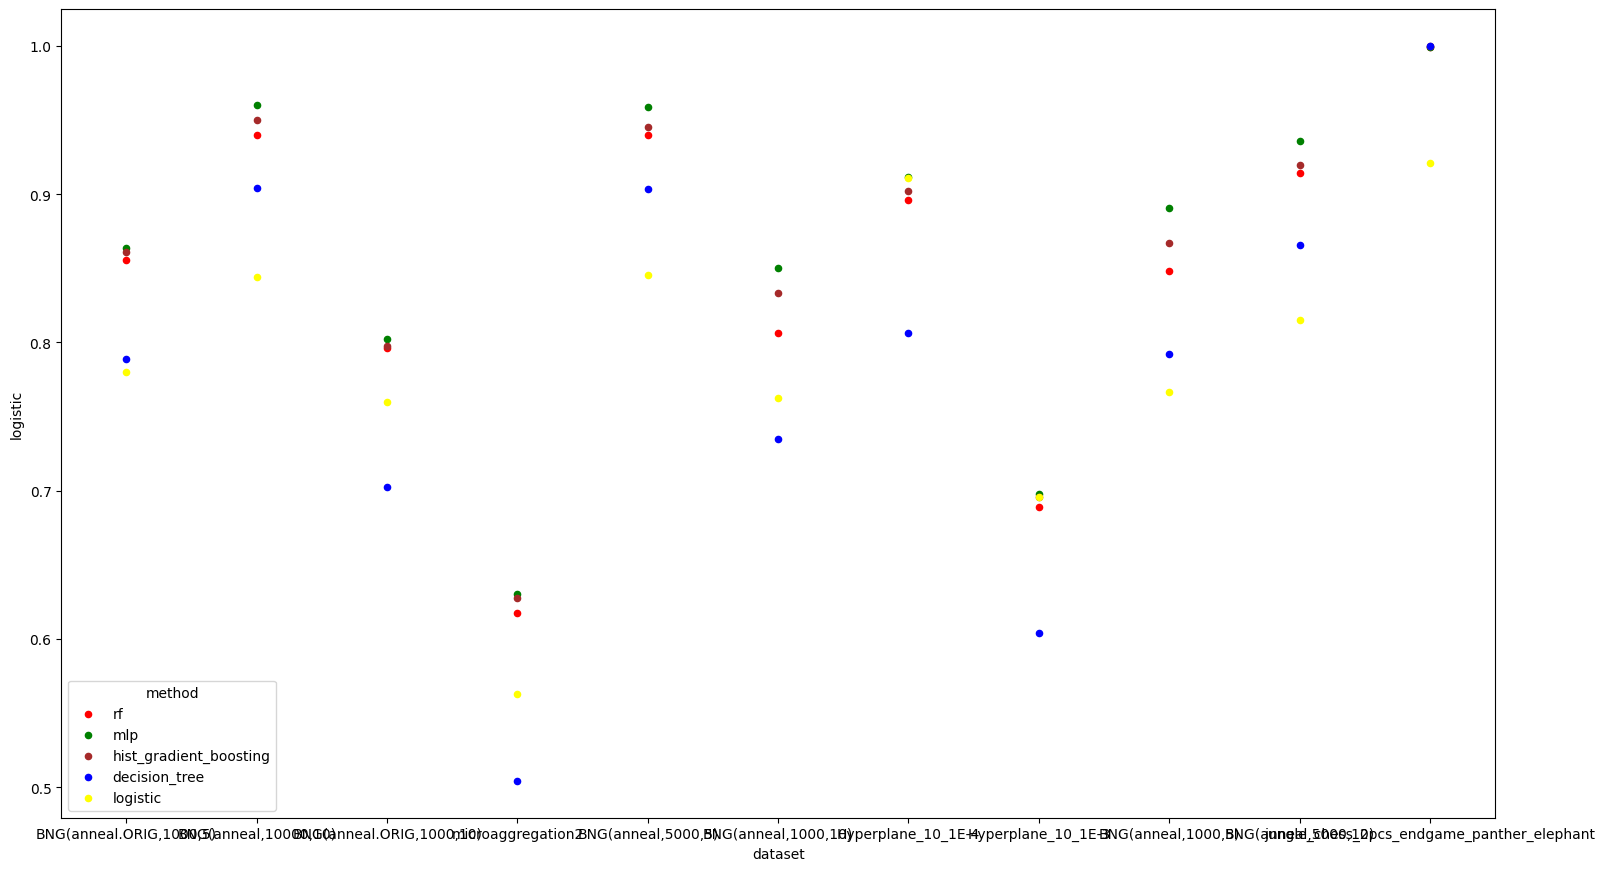

In [3]:
methods = ["rf", "mlp", "hist_gradient_boosting", "decision_tree", "logistic"]
colors = ["red", "green", "brown", "blue", "yellow"]

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

for i, method in enumerate(methods):
    plot_df.plot(kind="scatter", x="dataset", y=method, label=method, ax=ax, color=colors[i]) #.index

In [220]:
all_dataset_ids_numerical = [
    # 41986, 41988, 41989, 1053, 40996, 40997, 4134, 41000, 554, 41002, 44, 1590, 44089, 44090, 44091, 60, 1596, 41039, 1110, 44120, 1113, 44121, 44122, 44123, 44124, 44125, 1119, 44126, 44127, 44128, 44129, 44130, 44131, 150, 152, 153, 1181, 159, 160, 1183, 1185, 180, 1205, 182, 1209, 41146, 41147, 1212, 1214, 1216, 1218, 1219, 1222, 41671, 41162, 1226, 41163, 41164, 41166, 720, 41168, 41169, 725, 1240, 1241, 1242, 734, 735, 42206, 737, 40685, 246, 42742, 761, 250, 251, 252, 42746, 254, 42750, 256, 257, 258, 261, 266, 267, 269, 271, 279, 803, 816, 819, 823, 833, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 846, 847, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1368, 351, 357, 871, 42343, 1393, 1394, 1395, 42395, 4541, 42435, 1476, 1477, 1478, 1486, 976, 979, 40923, 23517, 1503, 43489, 1507, 42468, 42477, 41972, 1526, 41982
    # 44, 152, 153, 251, 256, 267, 269, 351, 357, 720, 725, 734, 735, 737, 761, 803, 816, 819, 823, 833, 846, 847, 871, 976, 979, 1053, 1119, 1240, 1241, 1242, 1486, 1507, 1590, 4134, 23517, 41146, 41147, 41162, 42206, 42343, 42395, 42435, 42477, 42742, 60, 150, 159, 160, 180, 182, 250, 252, 254, 261, 266, 271, 279, 554, 1110, 1113, 1183, 1185, 1209, 1214, 1222, 1226, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1368, 1393, 1394, 1395, 1476, 1477, 1478, 1503, 1526, 1596, 4541, 40685, 40923, 40996, 40997, 41000, 41002, 41039, 41163, 41164, 41166, 41168, 41169, 41671, 41972, 41982, 41986, 41988, 41989, 42468, 42746, 44089, 44090, 44091, 44120, 44121, 44122, 44123, 44124, 44125, 44126, 44127, 44128, 44129, 44130, 44131
    152, 153, 1240, 1352, 1353, 1355, 1356, 1359, 1361, 1362, 41000, 41671
]
for task_id in all_dataset_ids_numerical:
    # print(f"Running {task_id}")
    try:
        dataset = openml.datasets.get_dataset(task_id, download_data=False)
        print(dataset.name)
    except Exception as e:
        print(repr(e))
        continue
    # print(dataset)


Hyperplane_10_1E-3
Hyperplane_10_1E-4
AirlinesCodrnaAdult
BNG(anneal,1000,5)
BNG(anneal,1000,10)
BNG(anneal,5000,5)
BNG(anneal,5000,10)
BNG(anneal,10000,10)
BNG(anneal.ORIG,1000,5)
BNG(anneal.ORIG,1000,10)
jungle_chess_2pcs_endgame_panther_elephant
microaggregation2


In [20]:

all_dataset_ids_numerical = [
    41986, 41988, 41989, 1053, 40996, 40997, 4134, 41000, 554, 41002, 44, 1590, 44089, 44090, 44091, 60, 1596, 41039, 1110, 44120, 1113, 44121, 44122, 44123, 44124, 44125, 1119, 44126, 44127, 44128, 44129, 44130, 44131, 150, 152, 153, 1181, 159, 160, 1183, 1185, 180, 1205, 182, 1209, 41146, 41147, 1212, 1214, 1216, 1218, 1219, 1222, 41671, 41162, 1226, 41163, 41164, 41166, 720, 41168, 41169, 725, 1240, 1241, 1242, 734, 735, 42206, 737, 40685, 246, 42742, 761, 250, 251, 252, 42746, 254, 42750, 256, 257, 258, 261, 266, 267, 269, 271, 279, 803, 816, 819, 823, 833, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 846, 847, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1368, 351, 357, 871, 42343, 1393, 1394, 1395, 42395, 4541, 42435, 1476, 1477, 1478, 1486, 976, 979, 40923, 23517, 1503, 43489, 1507, 42468, 42477, 41972, 1526, 41982
]
all_dataset_ids_categorical = [
    24, 26, 154, 179, 274, 350, 720, 881, 923, 959, 981, 993, 1110, 1112, 1113, 1119, 1169, 1240, 1461, 1486, 1503, 1568, 1590, 4534, 4541, 40517, 40672, 40997, 40998, 41000, 41002, 41003, 41006, 41147, 41162, 41440, 41672, 42132, 42192, 42193, 42206, 42343, 42344, 42345, 42477, 42493, 42732, 42734, 42742, 42746, 42750, 43044, 43439, 43489, 43607, 43890, 43892, 43898, 43903, 43904, 43920, 43922, 43923, 43938, 44156, 44157, 44159, 44160, 44161, 44162, 44186
]
openml_list = openml.datasets.list_datasets(all_dataset_ids_numerical + all_dataset_ids_categorical)

sorted(openml_list, key= lambda d: openml_list[d]["NumberOfInstances"] * openml_list[d]["NumberOfFeatures"])

[44127,
 737,
 871,
 1526,
 44091,
 720,
 803,
 923,
 44160,
 819,
 725,
 816,
 42192,
 42193,
 43892,
 44126,
 847,
 735,
 41146,
 44124,
 43607,
 1568,
 26,
 959,
 43923,
 43938,
 44125,
 976,
 1507,
 44130,
 761,
 44157,
 44089,
 44090,
 823,
 24,
 43922,
 60,
 979,
 42493,
 40997,
 40998,
 41000,
 43904,
 44123,
 182,
 1053,
 43890,
 44186,
 44,
 833,
 44122,
 41002,
 41003,
 41006,
 44162,
 44120,
 846,
 1222,
 4534,
 44156,
 251,
 41671,
 993,
 881,
 1119,
 734,
 40685,
 981,
 43920,
 42477,
 43898,
 179,
 1590,
 1461,
 41440,
 42734,
 43439,
 42345,
 1476,
 1477,
 41169,
 41972,
 23517,
 43903,
 43044,
 41162,
 40672,
 44131,
 279,
 44161,
 44128,
 42344,
 1503,
 1486,
 1169,
 41672,
 351,
 1241,
 350,
 41168,
 1219,
 4541,
 1478,
 180,
 44121,
 41164,
 4134,
 1226,
 42750,
 357,
 1242,
 41166,
 152,
 153,
 159,
 160,
 1112,
 1209,
 266,
 267,
 1185,
 42468,
 1216,
 1205,
 1214,
 43489,
 258,
 246,
 261,
 42732,
 269,
 41163,
 1113,
 42206,
 257,
 44159,
 44129,
 1218,
 154,
 13

In [17]:
import openml
#openml.config.apikey = 'FILL_IN_OPENML_API_KEY'  # set the OpenML Api Key
# SUITE_ID = 297 # Regression on numerical features
SUITE_ID_1 = 298 # Classification on numerical features
#SUITE_ID = 299 # Regression on numerical and categorical features
SUITE_ID_2 = 304 # Classification on numerical and categorical features
benchmark_suite = openml.study.get_suite(SUITE_ID_1)  # obtain the benchmark suite
for task_id in benchmark_suite.tasks:  # iterate over all tasks
    task = openml.tasks.get_task(task_id, download_data=False)  # download the OpenML task
    # dataset = openml.datasets.get_dataset(dataset_id=task.dataset_id)
    print(task.dataset_id)
print("\n\n Starting suite 2")
benchmark_suite = openml.study.get_suite(SUITE_ID_2)  # obtain the benchmark suite
for task_id in benchmark_suite.tasks:  # iterate over all tasks
    task = openml.tasks.get_task(task_id, download_data=False)  # download the OpenML task
    # dataset = openml.datasets.get_dataset(dataset_id=task.dataset_id)
    print(task.dataset_id)

44089
44090
44091
44120
44121
44122
44123
44124
44125
44126
44127
44128
44129
44130
44131


 Starting suite 2
44156
44157
44159
44160
44161
44162
44186


In [ ]:
!git clone https://github.com/automl/TabPFN 
!cd TabPFN; git checkout b6e817b017595675c32a756d1b2fb352a8e800c0
!pip install "./TabPFN"
# !pip install -r TabPFN/requirements.txt
# !git clone https://github.com/noahho/TabPFNResults
# !cd TabPFNResults; git checkout c40dc9ff41aa345c1a355ca2e32e06eee534eb82 
!pip install -U torchmetrics seaborn matplotlib
raise Exception("restart the notebook please")

In [ ]:
%load_ext autoreload
%autoreload 2

# Imports

In [130]:
from __future__ import annotations

import argparse
import pickle
import re
from tqdm import tqdm
from collections import Counter
from dataclasses import dataclass
from functools import partial
from itertools import chain, product
import os
from pathlib import Path
import random
from typing import Callable, Iterable, Sequence

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.lines import Line2D

import tabpfn.scripts.tabular_baselines as tb
from tabpfn.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from tabpfn.scripts.tabular_baselines import clf_dict
from tabpfn.scripts.tabular_evaluation import evaluate
from tabpfn.scripts.tabular_metrics import (accuracy_metric, auc_metric,
                                            brier_score_metric,
                                            calculate_score, cross_entropy,
                                            ece_metric, time_metric)

from submitit import SlurmExecutor, AutoExecutor



# Constants

In [134]:
HERE = Path(".").resolve().absolute()

METRICS = {
    "roc": auc_metric,
    "cross_entropy": cross_entropy,
    "acc": accuracy_metric,
    "brier_score": brier_score_metric,
    "ece": ece_metric,
}

PREDEFINED_RESULTS_PATH = Path("/work/dlclarge1/rkohli-results_tabpfn_180/") # HERE / "TabPFNResults" / "all_results"
PREDFINED_DATASET_PATHS = HERE / "tabpfn" / "datasets" # / "TabPFN" 
PREDEFINED_DATASET_COLLECTIONS = {
    "cc_valid": {
        "ids": open_cc_valid_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_valid_datasets_multiclass.pickle",
    },
    "cc_test": {
        "ids": open_cc_dids,
        "path": PREDFINED_DATASET_PATHS / "cc_test_datasets_multiclass.pickle",
    },
}


LABEL_NAMES = {
    "transformer": "TabPFN",
    "transformer_gpu_N_1": "TabPFN GPU (N_ens =  1)",
    "transformer_gpu_N_4": "TabPFN GPU (N_ens =  4)",
    "transformer_gpu_N_8": "TabPFN GPU (N_ens =  8)",
    "transformer_gpu_N_32": "TabPFN GPU (N_ens = 32)",
    "transformer_cpu_N_1": "TabPFN CPU (N_ens =  1)",
    "transformer_cpu_N_4": "TabPFN CPU (N_ens =  4)",
    "transformer_cpu_N_8": "TabPFN CPU (N_ens =  8)",
    "transformer_cpu_N_32": "TabPFN CPU (N_ens = 32)",
    "autogluon": "Autogluon",
    "autosklearn2": "Autosklearn2",
    "gp_default": "default GP (RBF)",
    "gradient_boosting": "tuned Grad. Boost.",
    "gradient_boosting_default": "default Grad. Boost.",
    "lightgbm": "tuned LGBM",
    "lightgbm_default": "default LGBM",
    "gp": "tuned GP (RBF)",
    "logistic": "tuned Log. Regr.",
    "knn": "tuned KNN",
    "catboost": "tuned Catboost",
    "catboost_default": "default Catboost",
    "xgb": "tuned XGB",
    "xgb_default": "default XGB",
    "catboost_gpu": "tuned Catboost (GPU)",
    "catboost_default_gpu": "default Catboost (GPU)",
    "xgb_gpu": "tuned XGB (GPU)",
    "xgb_default_gpu": "default XGB (GPU)",
    "svm": "tuned SVM",
    "svm_default": "default SVM",
    "random_forest": "tuned Random Forest",
    "rf_default_n_estimators_10": "Rand. Forest (N_est =  10)",
    "rf_default_n_estimators_32": "Rand. Forest (N_est =  32)",
    "rf_default": "Rand. Forest (N_est = 100)",
    "autogluon": "AutoGluon",
    "autosklearn": "AutoSklearn"
}
FAMILY_NAMES = {
    "gp": "GP",
    "knn": "KNN",
    "lightgbm": "LGBM",
    "logistic": "Log. Regr.",
    "rf": "RF",
    "svm": "SVM",
    "transformer_cpu": "TabPFN CPU",
    "transformer_gpu": "TabPFN GPU",
    "xgb": "XGB CPU",
    "xgb_gpu": "XGB GPU",
    "catboost": "CatBoost CPU",
    "catboost_gpu": "CatBoost GPU",
    "autogluon": "AutoGluon",
    "autosklearn": "AutoSklearn",
    "autosklearn2": "AutoSklearn2",

}


# Available Methods

In [3]:
# Predefined methods with `no_tune={}` inidicating they are not tuned
METHODS = {
    # svm
    "svm": tb.svm_metric,
    "svm_default": partial(tb.svm_metric, no_tune={}),
    # # gradient boosting
    # "gradient_boosting": tb.gradient_boosting_metric,
    "gradient_boosting_default": partial(tb.gradient_boosting_metric, no_tune={}),
    # gp
    "gp": clf_dict["gp"],
    "gp_default": partial(
        clf_dict["gp"],
        no_tune={"params_y_scale": 0.1, "params_length_scale": 0.1},
    ),
    # autogluon
    "autogluon": clf_dict["autogluon"],
    # autosklearn
    # "autosklearn": clf_dict["autosklearn"],
    # lightgbm
    "lightgbm": clf_dict["lightgbm"],
    "lightgbm_default": partial(clf_dict["lightgbm"], no_tune={}),
    # catboost
    "catboost": clf_dict["catboost"],
    "catboost_default": partial(clf_dict["catboost"], no_tune={}),
    # "catboost_gpu": partial(clf_dict["catboost"], gpu_id=0),
    # "catboost_default_gpu": partial(clf_dict["catboost"], no_tune={}, gpu_id=0),
    # xgb
    "xgb": clf_dict["xgb"],
    "xgb_default": partial(clf_dict["xgb"], no_tune={}),
    "xgb_gpu": partial(clf_dict["xgb"], gpu_id=0),
    "xgb_default_gpu": partial(clf_dict["xgb"], gpu_id=0, no_tune={}),
    # random forest
    "random_forest": clf_dict["random_forest"],
    "rf_default": partial(clf_dict["random_forest"], no_tune={}),
    "rf_default_n_estimators_10": partial(
        clf_dict["random_forest"], no_tune={"n_estimators": 10}
    ),
    "rf_default_n_estimators_32": partial(
        clf_dict["random_forest"], no_tune={"n_estimators": 32}
    ),
    # knn
    "knn": clf_dict["knn"],
    # logistic classification
    "logistic": clf_dict["logistic"],
    # Transformers
    "transformer_cpu_N_1": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=1
    ),
    "transformer_cpu_N_4": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=4
    ),
    "transformer_cpu_N_8": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=8
    ),
    "transformer_cpu_N_32": partial(
        clf_dict["transformer"], device="cpu", N_ensemble_configurations=32
    ),
    "transformer_gpu_N_1": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=1
    ),
    "transformer_gpu_N_4": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=4
    ),
    "transformer_gpu_N_8": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=8
    ),
    "transformer_gpu_N_32": partial(
        clf_dict["transformer"], device="cuda", N_ensemble_configurations=32
    ),
}

# Classes

### Dataset

In [135]:
@dataclass
class Dataset:
    """Small helper class just to name entries in the loaded pickled datasets."""

    name: str
    X: torch.Tensor
    y: torch.Tensor
    categorical_columns: list[int]
    attribute_names: list[str]
    # Seems to be some things about how the dataset was constructed
    info: dict
    # Only 'multiclass' is known?
    task_type: str

    @property
    def categorical(self) -> bool:
        return len(self.categorical_columns) == len(self.attribute_names)

    @property
    def numerical(self) -> bool:
        return len(self.categorical_columns) == 0

    @property
    def mixed(self) -> bool:
        return not self.numerical and not self.categorical

    @classmethod
    def fetch(
        self,
        identifier: str | int | list[int],
        only: Callable | None = None,
    ) -> list[Dataset]:
        if isinstance(identifier, str) and identifier in PREDEFINED_DATASET_COLLECTIONS:
            datasets = Dataset.from_predefined(identifier)
        elif isinstance(identifier, int):
            identifier = [identifier]
            datasets = Dataset.from_openml(identifier)
        elif isinstance(identifier, list):
            datasets = Dataset.from_openml(identifier)
        else:
            raise ValueError(identifier)

        if only:
            return list(filter(only, datasets))
        else:
            return datasets

    @classmethod
    def from_pickle(self, path: Path, task_types: str) -> list[Dataset]:
        with path.open("rb") as f:
            raw = pickle.load(f)

        return [Dataset(*entry, task_type=task_types) for entry in raw]  # type: ignore

    @classmethod
    def from_predefined(self, name: str) -> list[Dataset]:
        assert name in PREDEFINED_DATASET_COLLECTIONS
        path = PREDEFINED_DATASET_COLLECTIONS[name]["path"]

        return Dataset.from_pickle(path, task_types="multiclass")

    @classmethod
    def from_openml(
        self,
        dataset_id: int | list[int],
        filter_for_nan: bool = False,
        min_samples: int = 100,
        max_samples: int = 2_000,
        num_feats: int = 100,
        return_capped: bool = False,
        shuffled: bool = True,
        multiclass: bool = True,
    ) -> list[Dataset]:
        # TODO: should be parametrized, defaults taken from ipy notebook
        if not isinstance(dataset_id, list):
            dataset_id = [dataset_id]

        datasets, _ = load_openml_list(
            dataset_id,
            filter_for_nan=filter_for_nan,
            num_feats=num_feats,
            min_samples=min_samples,
            max_samples=max_samples,
            return_capped=return_capped,
            shuffled=shuffled,
            multiclass=multiclass,
        )
        return [
            Dataset(  # type: ignore
                *entry,
                task_type="multiclass" if multiclass else "binary",
            )
            for entry in datasets
        ]

    def as_list(self) -> list:
        """How the internals expect a dataset to look like."""
        return [
            self.name,
            self.X,
            self.y,
            self.categorical_columns,
            self.attribute_names,
            self.info,
        ]

### Results

In [5]:
@dataclass
class Results:
    # Big ass predefined dictionary
    df: pd.DataFrame

    @classmethod
    def from_dict(
        self,
        d: dict,
        datasets: list[Dataset],
        recorded_metrics: list[str],
        *,
        dropna: bool = True,
    ) -> Results:
        # TODO: we could extract dataset_names for the dict but it's not ordered well
        #   for that. Likewise for the recorded_metrics
        #
        # We do a lot of parsing here to massage things into a nice table
        # Extract all the times listed in the keys
        pattern = re.compile(
            r"(?P<method>\w+)"
            r"_time_(?P<time>\d+(\.\d+)?)"
            r"(_)?(?P<metric>\w+)"
            r"_split_(?P<split>\d+)"
        )

        groups = []
        for key in d:
            match = re.match(pattern, key)
            if not match:
                raise ValueError(key)

            groups.append(match.groupdict())

        matches = pd.DataFrame(groups)

        # The unique, methods, times, metrics and splits present
        methods = list(matches["method"].unique())
        times = list(matches["time"].astype(float).unique())
        metrics = list(matches["metric"].unique())
        splits = list(matches["split"].astype(int).unique())

        # Next we extract all the eval_positions
        _eval_positions = set()
        for v in d.values():
            _eval_positions.update(v["eval_positions"])
        eval_positions = sorted(_eval_positions)

        # Dataset names...
        dataset_names = sorted([d.name for d in datasets])

        # We flatten out the fit_time and inference_time of best_config
        for (k, v), pos, dataset in product(d.items(), eval_positions, datasets):
            old_best_configs_key = f"{dataset.name}_best_configs_at_{pos}"

            best_config_key = f"{dataset.name}_best_config"
            inference_time_key = f"{dataset.name}_inference_time_at_{pos}"
            fit_time_key = f"{dataset.name}_fit_time_at_{pos}"

            # If there is a best config
            if any(v.get(old_best_configs_key, [])):
                assert len(v[old_best_configs_key]) == 1

                best_config = v[old_best_configs_key][0]

                v[inference_time_key] = best_config.get("inference_time", np.nan)
                v[fit_time_key] = best_config.get("fit_time", np.nan)
                v[best_config_key] = best_config.copy()
                del v[old_best_configs_key]
            else:
                v[inference_time_key] = np.nan
                v[fit_time_key] = np.nan
                v[best_config_key] = np.nan

        index = pd.MultiIndex.from_product(
            [methods, metrics, times, eval_positions, splits],
            names=[
                "method",
                "optimization_metric",
                "optimization_time",
                "eval_position",
                "split",
            ],
        )

        metrics = recorded_metrics + ["time", "inference_time", "fit_time"]
        columns = pd.MultiIndex.from_product(
            [metrics, dataset_names],
            names=["metric", "dataset"],
        )

        df = pd.DataFrame(columns=columns, index=index)
        df.sort_index(inplace=True)

        for k, v in d.items():
            match = re.match(pattern, k)
            if match is None:
                raise ValueError(k)

            method = match.group("method")
            time = float(match.group("time"))
            opt_metric = match.group("metric")
            split = int(match.group("split"))

            for dataset, metric, pos in product(dataset_names, metrics, eval_positions):
                row = (method, opt_metric, time, int(pos), split)
                col = (metric, dataset)

                value = v.get(f"{dataset}_{metric}_at_{pos}", np.nan)

                df.loc[row, col] = value

        # Drop full NaN rows
        if dropna:
            df = df[df.any(axis=1)]

        return Results(df)

    def at(
        self,
        *,
        method: str | list[str] | None = None,
        optimization_metric: str | list[str] | None = None,
        optimization_time: float | list[float] | None = None,
        split: int | list[int] | None = None,
        eval_position: int | list[int] | None = None,
        dataset: str | list[str] | None = None,
        metric: str | list[str] | None = None,
    ) -> Results:
        """Use this for slicing in to the dataframe to get what you need"""
        df = self.df
        items = {
            "method": method,
            "optimization_time": optimization_time,
            "optimization_metric": optimization_metric,
            "split": split,
            "eval_position": eval_position,
        }
        for name, item in items.items():
            if item is None:
                continue
            idx: list = item if isinstance(item, list) else [item]
            df = df[df.index.get_level_values(name).isin(idx)]
            if not isinstance(item, list):
                df = df.droplevel(name, axis="index")

        if dataset:
            _dataset = dataset if isinstance(dataset, list) else [dataset]
            df = df.T.loc[df.T.index.get_level_values("dataset").isin(_dataset)].T
            if not isinstance(dataset, list):
                df = df.droplevel("dataset", axis="columns")

        if metric:
            _metric = metric if isinstance(metric, list) else [metric]
            df = df.T.loc[df.T.index.get_level_values("metric").isin(_metric)].T
            if not isinstance(metric, list):
                df = df.droplevel("metric", axis="columns")

        return Results(df)

    @property
    def methods(self) -> list[str]:
        return list(self.df.index.get_level_values("method").unique())

    @property
    def optimization_metrics(self) -> list[str]:
        return list(self.df.index.get_level_values("optimization_metric").unique())

    @property
    def optimization_times(self) -> list[float]:
        return list(self.df.index.get_level_values("optimization_time").unique())

    @property
    def eval_positions(self) -> list[int]:
        return list(self.df.index.get_level_values("eval_position").unique())

    @property
    def datasets(self) -> list[str]:
        return list(self.df.columns.get_level_values("dataset").unique())

    @property
    def metrics(self) -> list[str]:
        return list(self.df.columns.get_level_values("metric").unique())

### Plotter

## utils

In [6]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import os
import numpy as np
import pandas as pd
import matplotlib
# import Orange

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

from dataclasses import dataclass

ALGORITHM_COLUMN_NAME = 'method'
PERFORMANCE_METRIC_COLUMN_NAME = 'roc_auc'
TASK_COLUMN_NAME = 'Dataset'


# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(ax, avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    # fig = plt.figure(figsize=(width, height))
    # fig.set_facecolor('white')
    # ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.2f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    # print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        # print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height
    return ax

def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)

def wilcoxon_holm(df_perf, alpha=0.05):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf[ALGORITHM_COLUMN_NAME]))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        [ALGORITHM_COLUMN_NAME]).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       [ALGORITHM_COLUMN_NAME])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    
    try:
        friedman_p_value = friedmanchisquare(*(
            np.array(df_perf.loc[df_perf[ALGORITHM_COLUMN_NAME] == c][PERFORMANCE_METRIC_COLUMN_NAME])
            for c in classifiers))[1]
        if friedman_p_value >= alpha:
            # then the null hypothesis over the entire classifiers cannot be rejected
            # open('null_hypethesis_rejected.txt', 'w').write('the null hypothesis over the entire classifiers cannot be rejected')
            exit()
    except:
        pass

    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    better_classifiers = []
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf[ALGORITHM_COLUMN_NAME] == classifier_1][PERFORMANCE_METRIC_COLUMN_NAME]
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf[ALGORITHM_COLUMN_NAME] == classifier_2]
                              [PERFORMANCE_METRIC_COLUMN_NAME], dtype=np.float64)
            diff_perf = perf_1-perf_2
            wins = sum(diff_perf>0)
            tie = sum(diff_perf==0)
            loss = sum(diff_perf<0)
            if wins > loss:
                winner = classifier_1
            else:
                winner = classifier_2
            # calculate the p_value
            p_value = np.around(wilcoxon(perf_1, perf_2, zero_method='pratt')[1], decimals=4)
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
            better_classifiers.append(
                {'classifier_1': classifier_1,
                'classifier_2': classifier_2,
                'p_value': p_value,
                'winner': winner,
                'wins': wins,
                'tie': tie,
                'loss': loss})

    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))
    better_classifiers.sort(key=operator.itemgetter('p_value'))
    better_classifiers = pd.DataFrame(better_classifiers)
    # get_according_to_thesis(better_classifiers).T.to_csv(f"{out_dir}/cd_comparison_pairwise_{setname}_display.csv")
    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], p_values[i][2] <= new_alpha)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf[ALGORITHM_COLUMN_NAME].isin(classifiers)]. \
        sort_values([ALGORITHM_COLUMN_NAME, TASK_COLUMN_NAME])
    # get the rank data
    rank_data = np.array(sorted_df_perf[PERFORMANCE_METRIC_COLUMN_NAME]).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf[TASK_COLUMN_NAME]))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    # print(dfff)  # [dfff == 1.0].sum(axis=1))
    # dfff.T.to_csv(os.path.join(out_dir, "rank_per_task.csv"))
    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # average_ranks.T.to_csv(os.path.join(out_dir, "average_ranks_per_task.csv"))
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets



In [7]:
@dataclass
class Plotter:
    result: Results

    def cd_plot(
        self,
        *,
        method = None,
        eval_position: int = 1_000,
        optimization_time: float = 30.0,
        optimization_metric: str = "roc_auc",
        metric: str = "acc",
        legend: str = "box",  # box, text
        alpha: float= 0.05,
        highlighted_families: Sequence[str] = FAMILY_NAMES.keys(),
        # (
        #    "transformer_cpu",
        #    "transformer_gpu",
        #    "xgb",
        #    "rf",
        # ),
        ax: plt.Axes,
    ) -> plt.Axes:
        # assert all(f in FAMILY_NAMES for f in highlighted_families)
        r = self.result.at(
            method=method,
            optimization_metric=optimization_metric,
            optimization_time=optimization_time,
            eval_position=eval_position,
            metric=[metric],
        )

        df = r.df.groupby(["method", "split"]).mean().groupby("method").mean().T
        # print(df.head())
        # drop metric from multiindex
        df = df.droplevel(0)
        # print(df.head())
        columns = df.columns
        # move dataset which is an index to a column
        df = df.reset_index()

        # concate mini dfs per method
        mini_dfs = []
        for column in columns:
            t_1_df = df[["dataset", column]].copy()
            t_1_df["method"] = column
            t_1_df.columns = ["Dataset", f"{optimization_metric}", "method"]
            mini_dfs.append(t_1_df)
        df = pd.concat(mini_dfs)

        p_values, average_ranks, num_datasets = wilcoxon_holm(df_perf=df, alpha=alpha)

        labels = [
            (
                LABEL_NAMES[method],
            )
            for method in r.methods]

        ax = graph_ranks(ax, [round(float(value), 2) for value in list(average_ranks.values)], average_ranks.keys(), p_values,
                    cd=None, reverse=True, width=9, textspace=1.5, labels=labels)
        
        return ax

    def overall_plot(
        self,
        *,
        eval_position: int = 1_000,
        optimization_time: float = 30.0,
        optimization_metric: str = "roc_auc",
        metric: str = "acc",
        legend: str = "box",  # box, text
        highlighted_families: Sequence[str] = FAMILY_NAMES.keys(),
        # (
        #    "transformer_cpu",
        #    "transformer_gpu",
        #    "xgb",
        #    "rf",
        # ),
        ax: plt.Axes,
    ) -> plt.Axes:
        assert all(f in FAMILY_NAMES for f in highlighted_families)
        quantile_pairs = [(0.05, 0.95), (0.25, 0.75)]
        quantile_mark = [(0.05, 0.95), (0.25, 0.75)]
        quantiles = sorted(set(chain.from_iterable(quantile_pairs)))

        s_point = 50
        s_median = 100
        alpha_point = 0.1
        alpha_family_join = 0.1
        q_alpha = {0: 0.2, 0.05: 0.3, 0.25: 0.5}
        q_linewidth = {0: 1, 0.05: 2, 0.25: 3}

        r = self.result.at(
            optimization_metric=optimization_metric,
            optimization_time=optimization_time,
            eval_position=eval_position,
            metric=[metric, "time"],
        )

        # metric        acc       time
        # method split
        # gp     0      0.786164  39.354000
        #        1      0.786164  38.317375
        # ...           ...        ...
        # xgb    19     0.794751   0.148113
        #        20     0.794751   0.148113
        df = r.df.groupby(["method", "split"]).mean().T.groupby("metric").mean().T

        # For dataset cross dataset aggregation
        # df = r.df.unstack(level="method").mean().unstack("metric").reset_index()

        #          | time                               metric
        # quantile | 0, 0.05, 0.25, 0.75, 0.95, 1, 0, 0.05, 0.25, 0.75, 0.95, 1
        # ---------------------------------------------------------------------
        # gp       |
        # ...      |
        # xgb      |
        qs = df.groupby("method").quantile(quantiles).unstack()
        qs.columns.names = [qs.columns.names[0], "quantiles"]

        #        | acc time
        # method |
        # gp     |
        # ...    |
        # xgb    |
        medians = df.groupby("method").agg({metric: "median", "time": "median"})

        families = set(map(Plotter.family, r.methods))

        palette = {
            h: c for h, c in zip(families, sns.color_palette(n_colors=len(families)))
        }

        # Tiny feint blobs for all points
        # methods = df.index.get_level_values("method")
        # df["family"] = [self.family(m) for m in method_list]
        # df["style"] = self.styles(method_list)
        # sns.scatterplot(
        # data=df,
        # x="time",
        # y=metric,
        # hue=hue,
        # style=style,
        # alpha=alpha_point,
        # ax=ax,
        # legend=False,
        # palette=palette,
        # s=s_point,
        # )

        # Quantiles
        # For each (method, quantile) we draw a H on both the time and metric axis
        # time
        times = qs["time"]
        metric_values = qs[metric]
        for method, (q_low, q_high) in product(qs.index, quantile_pairs):

            x = medians.loc[method]["time"]
            time_low = times[q_low].loc[method]
            time_high = times[q_high].loc[method]

            y = medians.loc[method][metric]
            metric_low = metric_values[q_low].loc[method]
            metric_high = metric_values[q_high].loc[method]

            family = Plotter.family(method)

            # Time
            time_marker = "|" if (q_low, q_high) in quantile_mark else None
            ax.plot(
                [time_low, time_high],
                [y, y],
                c=palette[family],
                alpha=q_alpha[q_low],
                linewidth=q_linewidth[q_low],
                marker=time_marker,
            )

            # Metric
            metric_marker = "_" if (q_low, q_high) in quantile_mark else None
            ax.plot(
                [x, x],
                [metric_low, metric_high],
                c=palette[family],
                alpha=q_alpha[q_low],
                linewidth=q_linewidth[q_low],
                marker=metric_marker,
            )

        # Big blob for medians
        medians["family"] = [Plotter.family(i) for i in medians.index]
        markers = self.markers(sorted(medians.index, key=lambda x: LABEL_NAMES[x]))

        for key, group in medians.groupby("method"):
            sns.scatterplot(
                data=group,
                x="time",
                y=metric,
                hue="family",
                ax=ax,
                palette=palette,
                s=s_median,
                marker=markers[key],
            )

        # https://matplotlib.org/stable/gallery/misc/transoffset.html#sphx-glr-gallery-misc-transoffset-py
        text_offset = mtransforms.offset_copy(ax.transData, x=10, y=20, units="dots")
        for family, group in medians.groupby("family"):
            if family not in highlighted_families:
                continue
            # Sort by the time axis
            xs, ys = zip(*sorted(zip(group["time"], group[metric])))
            ax.plot(xs, ys, c=palette[family], linestyle="--", alpha=alpha_family_join)

            l_xs = len(xs)
            mid_x, mid_y = xs[l_xs // 2], ys[l_xs // 2]
            ax.text(
                mid_x,
                mid_y,
                FAMILY_NAMES[family],
                transform=text_offset,
                c=palette[family],
                fontweight="bold",
            )

        ax.set_xscale("log")
        ticks = {0.5: "0.5s", 1: "1s", 5: "5s", 15: "15s", 30: "30s", 60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "1hr"}
        ax.set_xticks(list(ticks.keys()))
        ax.set_xticklabels(list(ticks.values()))

        # We unfortunatly have to create a manual legend just due to seaborn not being
        # very flexible in that respect
        family_methods = sorted([(self.family(m), m) for m in set(medians.index)])

        items = [
            (
                family,
                LABEL_NAMES[method],
                Line2D(
                    [],
                    [],
                    color=palette[family],
                    marker=markers[method],
                    linestyle="",
                ),
            )
            for family, method in family_methods
        ]
        # Sort just by family and label
        _, labels, handles = zip(*sorted(items, key=lambda x: x[:2]))

        # create a legend only using the items
        ax.legend(
            handles,
            labels,
            title="Method",
            fontsize=10,
        )

        ax.set_xlabel("Time taken (s)")
        ax.set_ylabel(metric)

        return ax

    @classmethod
    def family(cls, method: str) -> str:
        for f in FAMILY_NAMES:
            if method.startswith(f):
                return f

        # Exceptions
        if "random_forest" in method:
            return "rf"

        return method

    @classmethod
    def markers(cls, methods: Iterable[str]) -> dict[str, str]:
        markers = ["o", "v", "s", "D", "8", "X", "*"]
        styles: dict[str, str] = {}

        counter: Counter[str] = Counter()
        for method in methods:
            family = cls.family(method)
            idx = counter[family]
            styles[method] = markers[idx]
            counter[family] += 1

        return styles


# Functions

In [8]:
class BoschSlurmExecutor(SlurmExecutor):
    def _make_submission_command(self, submission_file_path):
        return ["sbatch", str(submission_file_path), '--bosch']


PARTITION_TO_EXECUTER = {
    'bosch': BoschSlurmExecutor,
    'other': AutoExecutor

}

def get_executer(partition: str) -> SlurmExecutor:
    if 'bosch' in partition:
        key = 'bosch'
    else:
        key = 'other'
    return PARTITION_TO_EXECUTER[key]


def get_executer_params(timeout: float, partition: str, gpu: bool = False):
    if gpu:
        return {'timeout_min': int(timeout), 'slurm_partition': partition}
    else:
        return {'time': int(timeout), 'partition': partition, 'mem_per_cpu': 6000, 'nodes': 1, 'cpus_per_task': 1, 'ntasks_per_node': 1}


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]


def set_seed(seed):
    # Setting up reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [9]:
def eval_method(
    datasets: list[Dataset],
    label: str,
    classifier_evaluator: Callable,
    max_time: float | None,
    metric_used: Callable,
    split: int,
    eval_positions: list[int],
    result_path: Path,
    append_metric: bool = True,
    fetch_only: bool = False,
    verbose: bool = False,
    bptt: int = 2000,
    overwrite: bool = False,
):
    """Evaluate a given method."""
    if max_time is not None:
        label += f"_time_{float(max_time)}"

    if append_metric:
        label += f"_{tb.get_scoring_string(metric_used, usage='')}"

    if isinstance(classifier_evaluator, partial):
        device = classifier_evaluator.keywords.get("device", "cpu")
    else:
        device = "cpu"

    task_type = "multiclass"
    if any(d.task_type != task_type for d in datasets):
        raise RuntimeError("Not sure how to handle this yet")

    return evaluate(
        datasets=[d.as_list() for d in datasets],
        model=classifier_evaluator,
        method=label,
        bptt=bptt,
        base_path=result_path,
        eval_positions=eval_positions,
        device=device,
        max_splits=1,
        overwrite=overwrite,
        save=True,
        metric_used=metric_used,
        path_interfix=task_type,
        fetch_only=fetch_only,
        split_id=split,
        verbose=verbose,
        max_time=max_time,
    )



def do_evaluations(args: argparse.Namespace, datasets: list[Dataset]) -> Results:
    results = {}
    for method, metric, time, split in product(
        args.methods,
        args.optimization_metrics,
        args.times,
        range(1, args.splits+1),
    ):
        metric_f = METRICS[metric]
        metric_name = tb.get_scoring_string(metric_f, usage="")
        key = f"{method}_time_{time}{metric_name}_split_{split}"

        print(f"Running {key}")
        results[key] = eval_method(
            datasets=datasets,
            label=method,
            result_path=args.result_path,
            classifier_evaluator=METHODS[method],
            eval_positions=args.eval_positions,  # It's a constant basically
            fetch_only=args.fetch_only,
            verbose=args.verbose,
            max_time=time,
            metric_used=metric_f,
            split=split,
            overwrite=args.overwrite,
        )

    datasets_as_list = [d.as_list() for d in datasets]

    # This will update the results in place
    for metric in args.recorded_metrics:
        metric_f = METRICS[metric]
        calculate_score(
            metric=metric_f,
            name=metric,
            global_results=results,
            ds=datasets_as_list,
            eval_positions=args.eval_positions,
        )

    # We also get the times
    calculate_score(
        metric=time_metric,
        name="time",
        global_results=results,
        ds=datasets_as_list,
        eval_positions=args.eval_positions,
    )

    return Results.from_dict(
        results,
        datasets=datasets,
        recorded_metrics=args.recorded_metrics + ["time"],
    )


def do_plot(
    result: Results,
    title_prefix: str,
    fig_name: str,
    path: Path,
    figsize: tuple[int, int] = (12, 10),
    dpi: int = 120,
    extension: str = "png",
    eval_position: int = 1_000,
    shift_legend: bool = True,
) -> None:
    for metric, opt_time, opt_metric in zip(
        [m for m in result.metrics if "time" not in m],
        result.optimization_times,
        result.optimization_metrics,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        Plotter(result).overall_plot(
            optimization_metric=opt_metric,
            optimization_time=opt_time,
            eval_position=eval_position,
            metric=metric,
            ax=axes,
        )
        axes.set_title(f"{title_prefix} [opt_time={opt_time}, opt_metric={opt_metric}]")

        if shift_legend:
            sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

        stem = f"{fig_name}_opt_metric_{opt_metric}_opt_time_{opt_time}_metric_{metric}"
        fig.savefig(path / f"{stem}.{extension}", bbox_inches="tight")
        plt.close()

In [10]:
def do_cd_plot(
    result: Results,
    title_prefix: str,
    fig_name: str,
    path: Path,
    figsize: tuple[int, int] = (12, 10),
    dpi: int = 120,
    extension: str = "png",
    eval_position: int = 1_000,
    shift_legend: bool = True,
    methods = None
) -> None:
    for metric, opt_time, opt_metric in zip(
        [m for m in result.metrics if "time" not in m],
        result.optimization_times,
        result.optimization_metrics,
    ):
        fig, axes = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
        Plotter(result).cd_plot(
            method=methods,
            optimization_metric=opt_metric,
            optimization_time=opt_time,
            eval_position=eval_position,
            metric=metric,
            ax=axes,
        )
        axes.set_title(f"{title_prefix} [opt_time={opt_time}, opt_metric={opt_metric}]")

        # if shift_legend:
        #     sns.move_legend(axes, "upper left", bbox_to_anchor=(1, 1))

        stem = f"{fig_name}_opt_metric_{opt_metric}_opt_time_{opt_time}_metric_{metric}"
        fig.savefig(path / f"{stem}.{extension}", bbox_inches="tight")
        plt.close()


<a name="experiment"></a>
# Experiment

In [11]:
from argparse import Namespace

# For your own custom evaluation, please comment out the one from below
# args = Namespace(
#     result_path=HERE, # Where to store results - HERE/results
#     gpu=True,  # Whether a GPU is accessible
#     times=[30], # How much optimization time is given to methods requiring it
#     splits=5, # How many splits to run
#     validation_datasets=[13, 59, 4], # "cc_valid" or list of openml ids
#     test_datasets=[973, 1596, 40981], # "cc_test" or list of openml ids
#     optimization_metrics=["roc"], # ["roc", "cross_entropy", "acc", "brier_score", "ece"]m
#     recorded_metrics=["roc", "cross_entropy", "acc", "brier_score", "ece"], # Same as above
#     methods=["rf_default", "transformer_gpu_N_8"], # See keys of METHODS in Constants section
#     fetch_only=False, # Will only fetch results and not compute anything
#     bptt=2_000, # Transformer sequence length
#     eval_positions=[1_000], # Leave as is
#     overwrite=False, # Will overwrite results
#     plot=True, # Do plots
#     plot_directory=HERE/ "plots",  # Where to store plots
#     figsize=(12, 10),  # The figure size for matplotlib
#     dpi=120,  # The DPI for figures by matplotlib
#     extension="png", # The extension for saving figures
#     verbose=True,

#     # Use this to use the predefined results from experiments
#     # See the commented out block below
#     load_predefined_results=False,
#     predefined_results_path=None,
# )

# This was used for generating the full overview plots,
# Comment out to use the above
args = Namespace(
    result_path=Path("/work/dlclarge1/rkohli-results_tabpfn_180/"), # HERE,
    gpu=True,
    times=[3600.0],
    splits=5,
    validation_datasets="cc_valid",
    test_datasets="cc_test",
    optimization_metrics=["roc"],
    recorded_metrics=["roc", "cross_entropy", "acc", "brier_score", "ece"],
    methods=list(METHODS.keys()),
    fetch_only=True,
    bptt=2_000,
    eval_positions=[1_000],
    overwrite=False,
    plot=True,
    plot_directory=HERE/ "plots_noah",
    figsize=(12, 10),
    chunk_size=10,
    dpi=120,
    extension="png",
    verbose=False,
    load_predefined_results=False,
    predefined_results_path=HERE, # / "TabPFNResults" / "all_results",
)



In [12]:
args

Namespace(bptt=2000, chunk_size=10, dpi=120, eval_positions=[1000], extension='png', fetch_only=True, figsize=(12, 10), gpu=True, load_predefined_results=False, methods=['svm', 'svm_default', 'gradient_boosting_default', 'gp', 'gp_default', 'autogluon', 'lightgbm', 'lightgbm_default', 'catboost', 'catboost_default', 'xgb', 'xgb_default', 'xgb_gpu', 'xgb_default_gpu', 'random_forest', 'rf_default', 'rf_default_n_estimators_10', 'rf_default_n_estimators_32', 'knn', 'logistic', 'transformer_cpu_N_1', 'transformer_cpu_N_4', 'transformer_cpu_N_8', 'transformer_cpu_N_32', 'transformer_gpu_N_1', 'transformer_gpu_N_4', 'transformer_gpu_N_8', 'transformer_gpu_N_32'], optimization_metrics=['roc'], overwrite=False, plot=True, plot_directory=PosixPath('/home/rkohli/TabPFN/plots_noah'), predefined_results_path=PosixPath('/home/rkohli/TabPFN'), recorded_metrics=['roc', 'cross_entropy', 'acc', 'brier_score', 'ece'], result_path=PosixPath('/work/dlclarge1/rkohli-results_tabpfn_180'), splits=5, test_da

In [13]:
import time
# We need to create some directories for this to work
out_dir = os.path.join(args.result_path, "results", "tabular", "multiclass") #, f"{time.time()}")
os.makedirs(out_dir, exist_ok=True
)
# We ignore the flags datasets
filter_f = lambda d: d.name != "flags"  # noqa: ignore

valid_datasets = Dataset.fetch(args.validation_datasets, only=filter_f)
test_datasets = Dataset.fetch(args.test_datasets, only=filter_f)

all_datasets = valid_datasets + test_datasets
all_datasets = all_datasets

if not args.load_predefined_results:
    result = do_evaluations(args, all_datasets)
else:
    headers = ["metric", "dataset"]
    indices = [
        "method",
        "optimization_metric",
        "optimization_time",
        "eval_position",
        "split",
    ]

    if Path("predefined_results.csv").exists():
        df = pd.read_csv(
            "predefined_results.csv",
            index_col=list(range(len(indices))),
            header=list(range(len(headers))),
        )
        result = Results(df)
    else:

        def read(_path: Path) -> dict:
            return np.load(_path, allow_pickle=True)
            # with _path.open("rb") as f:
            #     return pickle.load(f)

        def store_results(path):
            result = Results.from_dict(
                d,
                datasets=all_datasets,
                recorded_metrics=args.recorded_metrics,
            )
            result.df.to_csv(path, index=True)
            return

        d = {}
        for i, path in enumerate(args.predefined_results_path.iterdir()):
            if path.is_file():
                d[path.stem] = read(path)
            if i%1000 == 0:
                store_results()

        

Running svm_time_3600.0roc_auc_split_1
Execution failed: ('svm_time_3600.0_roc_auc', 'titanic')
Running svm_time_3600.0roc_auc_split_2
Execution failed: ('svm_time_3600.0_roc_auc', 'titanic')
Running svm_time_3600.0roc_auc_split_3
Execution failed: ('svm_time_3600.0_roc_auc', 'titanic')
Running svm_time_3600.0roc_auc_split_4
Running svm_time_3600.0roc_auc_split_5
Running svm_default_time_3600.0roc_auc_split_1
Running svm_default_time_3600.0roc_auc_split_2
Running svm_default_time_3600.0roc_auc_split_3
Running svm_default_time_3600.0roc_auc_split_4
Running svm_default_time_3600.0roc_auc_split_5
Running gradient_boosting_default_time_3600.0roc_auc_split_1
Running gradient_boosting_default_time_3600.0roc_auc_split_2
Running gradient_boosting_default_time_3600.0roc_auc_split_3
Running gradient_boosting_default_time_3600.0roc_auc_split_4
Running gradient_boosting_default_time_3600.0roc_auc_split_5
Running gp_time_3600.0roc_auc_split_1
Running gp_time_3600.0roc_auc_split_2
Running gp_time_36

TypeError: 'float' object is not iterable

In [165]:
test_datasets = Dataset.fetch("cc_test")
test_datasets

[Dataset(name='balance-scale', X=tensor([[3., 2., 3., 5.],
         [5., 1., 5., 1.],
         [3., 1., 5., 4.],
         ...,
         [1., 3., 5., 5.],
         [2., 3., 1., 2.],
         [3., 4., 3., 4.]]), y=tensor([2, 1, 2, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2,
         2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2,
         0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2,
         2, 0, 2, 2, 0, 2, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 0,
         0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 2, 2, 0,
         0, 2, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0,
         2, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 0,
         0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0,
         2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2,
         1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 

In [ ]:

if args.plot:
    args.plot_directory.mkdir(exist_ok=True, parents=True)

    collections = {
        "All Datasets": [d.name for d in all_datasets],
        "Categorical Datasets": [d.name for d in all_datasets if d.categorical],
        "Numerical Datasets": [d.name for d in all_datasets if d.numerical],
        "Mixed Datasets": [d.name for d in all_datasets if d.mixed],
        #
        "Validation Datasets": [d.name for d in valid_datasets],
        "Categorical Validation Datasets": [
            d.name for d in valid_datasets if d.categorical
        ],
        "Numerical Validation Datasets": [
            d.name for d in valid_datasets if d.numerical
        ],
        "Mixed Validation Datasets": [d.name for d in valid_datasets if d.mixed],
        #
        "Test Datasets": [d.name for d in test_datasets],
        "Categorical Test Datasets": [
            d.name for d in test_datasets if d.categorical
        ],
        "Numerical Test Datasets": [d.name for d in test_datasets if d.numerical],
        "Mixed Test Datasets": [d.name for d in test_datasets if d.mixed],
    }

    for name, datasets in tqdm(collections.items(), "Dataset Collections"):
        do_plot(
            result=result.at(dataset=datasets),
            title_prefix=f"{name} ({len(datasets)})",
            fig_name=name.replace(" ", "_").lower(),
            path=args.plot_directory,
            figsize=tuple(args.figsize),  # type: ignore
            dpi=args.dpi,
            extension=args.extension,
        )


In [ ]:
!pwd

In [ ]:
d.keys()

In [ ]:
args.predefined_results_path.iterdir()


In [ ]:
for path in args.predefined_results_path.iterdir():
    print(path)

In [ ]:
global_results = {}
overwrite=False

from tabpfn.scripts import tabular_baselines as tb
for method in METHODS.keys():
    for max_time in [3600.0]:
        for split_number in range(1, 6):
            results_key = method+'_time_'+str(max_time)+tb.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            global_results[results_key] = eval_method(test_datasets, 'multiclass', method, list(dids), 'test', 
                                                      eval_positions
                                                      , fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time,
                                                                                                                                    metric_used=metric_used, split_number=split_number)

In [ ]:
import glob
from eval_utils import METHODS

def get_len_d_names(method):
    all_d_names = []
    for path in glob.glob(f"/work/dlclarge1/rkohli-results_tabpfn_180/results/tabular/multiclass/results_{method}_time_3600.0_roc_auc_*.npy"):
        all_d_names.append(path.split('.')[-2].split('_')[-4])
    return len(all_d_names)

for method in ["transformer_gpu_N_1", "transformer_gpu_N_4", "transformer_gpu_N_8", "transformer_gpu_N_32"]:
    print(method, get_len_d_names(method))


j = 0
for file_name in os.listdir("/home/rkohli/TabPFN/multiclass"):
    if '3600.0r' in file_name:
        j+=1